In [1]:
import intake
from pathlib import Path
import numpy as np
import xarray as xr

import xgcm
import cf_xarray

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj
import cmocean as cm
import cartopy.feature as cft

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42193,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:33203,Total threads: 1
Dashboard: /proxy/37831/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:34359,


2025-03-06 10:07:12,959 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:33397 (pid=1581734) exceeded 95% memory budget. Restarting...
2025-03-06 10:07:13,086 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:33397' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('getitem-5f4006d129ca0daa1148506bac16cfac', 0, 0, 2, 2, 5, 4), ('getitem-5f4006d129ca0daa1148506bac16cfac', 0, 0, 4, 1, 5, 4), ('getitem-5f4006d129ca0daa1148506bac16cfac', 0, 0, 5, 3, 3, 5), ('getitem-5f4006d129ca0daa1148506bac16cfac', 0, 0, 5, 1, 3, 0), ('getitem-5f4006d129ca0daa1148506bac16cfac', 0, 0, 5, 1, 5, 3), ('getitem-5f4006d129ca0daa1148506bac16cfac', 0, 0, 5, 1, 4, 5), ('getitem-5f4006d129ca0daa1148506bac16cfac', 0, 0, 1, 2, 5, 4), ('getitem-5f4006d129ca0daa1148506bac16cfac', 0, 0, 3, 1, 5, 3), ('getitem-5f4006d129ca0daa1148506bac16cfac', 0, 0, 5, 1, 0, 4), ('getitem-5f4006d129ca0daa1148506bac16cfac', 0, 0, 5, 1, 2, 4), ('rechunk-split-rechun

In [5]:
pancontrol01 = intake.open_esm_datastore('/home/272/kc5856/panantrial/experiment_datastore.json', columns_with_iterables=['variable'])
pantrial01 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/experiment_datastore.json', columns_with_iterables=['variable'])

In [6]:
uo = pantrial01.search(variable="uo", frequency="1mon").to_dask()
vo = pantrial01.search(variable="vo", frequency="1mon").to_dask()

In [7]:
u = uo.uo.sel(yh = slice(-80, -59), z_l = slice(None, 500)).sel(time=slice('2001-01-01','2010-12-31')).mean('time')
v = vo.vo.sel(yq = slice(-80, -59), z_l = slice(None, 500)).sel(time=slice('2001-01-01','2010-12-31')).mean('time')

In [8]:
pert_n = xr.merge([u,v])
pert_n= pert_n.isel(xq = slice(1, None), yq = slice(1, None))

In [9]:
path_to_ocean_static = Path('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output021/20010701.ocean_static.nc')
ocean_static = xr.open_dataset(path_to_ocean_static)

In [10]:
ocean_static = ocean_static.sel(xq = pert_n['xq'], xh = pert_n['xh'], yq = pert_n['yq'], yh = pert_n['yh'])

grid = xgcm.Grid(ocean_static, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                     'Y': {'center': 'yh', 'right': 'yq'}},
                                   periodic = ['X'])

In [11]:
dh_dx = grid.interp(grid.diff(ocean_static['deptho'], 'X') / ocean_static['dxCu'], 'Y')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [12]:
dh_dy = grid.interp(grid.diff(ocean_static['deptho'], 'Y') / ocean_static['dyCv'], 'X')

In [13]:
u_int = grid.interp(pert_n['uo'], 'Y')
v_int = grid.interp(pert_n['vo'], 'X')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [14]:
slope = np.sqrt(dh_dy**2 + dh_dx**2)

In [15]:
test = u_int*dh_dy - v_int*dh_dx

In [16]:
test = test.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 21.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [17]:
alongslope_velocity = test/slope

In [18]:
alongslope_velocity = alongslope_velocity.load()

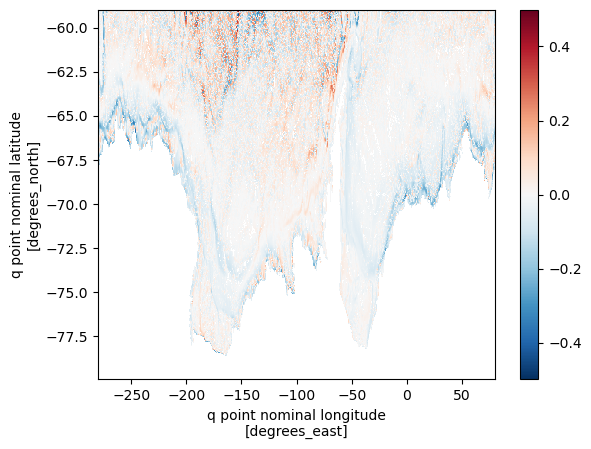

In [21]:
alongslope_velocity.isel(z_l=0).plot()

In [41]:
data_fixed = pantrial01.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()
volcello = pantrial01.search(variable=["volcello"],path=".*output021.*",file_id=["XXXXXXXX_ocean_month_z"]).to_dask()
#volcello = volcello.sel(time=slice('2001-01-01','2010-12-31')).mean('time')
area = data_fixed.areacello
thickness = volcello / area
thickness = thickness.sel(yh=slice(-80, -59)).sel(z_l=slice(None, 500))

In [48]:
alongslope_velocity = grid.interp(alongslope_velocity, 'Y')
#alongslope_velocity = grid.interp(alongslope_velocity, 'X')
alongslope_velocity

<xarray.DataArray (z_l: 39, yh: 483, xh: 3600)> Size: 271MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.08940504, -0.07967509, -0.05811799, ..., -0.00523714,
         -0.01573228, -0.06685726],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.02884635, -0.0241676 , -0.02006177, ...,  0.00751055,
          0.00280324, -0.01881072],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.02739282, -0.02300459, -0.01905796, ...,  0.00679839,
          0.00235938, -0.0179358 ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.97 -79.93 -79.88 ... -59.14 -59.08 -59.03
Dimensions without coordinates: z_l

In [49]:
# Depth average gives us the barotropic velocity
barotropic_alongslope_velocity = (alongslope_velocity * thickness['volcello']).sum('z_l') / thickness['volcello'].sum('z_l')
#barotropic_alongslope_velocity = barotropic_alongslope_velocity['volcello'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')

In [50]:
barotropic_alongslope_velocity = barotropic_alongslope_velocity.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 259.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [56]:
barotropic_alongslope_velocity=barotropic_alongslope_velocity.mean('time')

# Plotting

In [73]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.275
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [65]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

In [66]:
def shelf_mask_isobath(var, model_dict):

    paths = {"mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc", 
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [67]:
depth = data_fixed.deptho
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6')

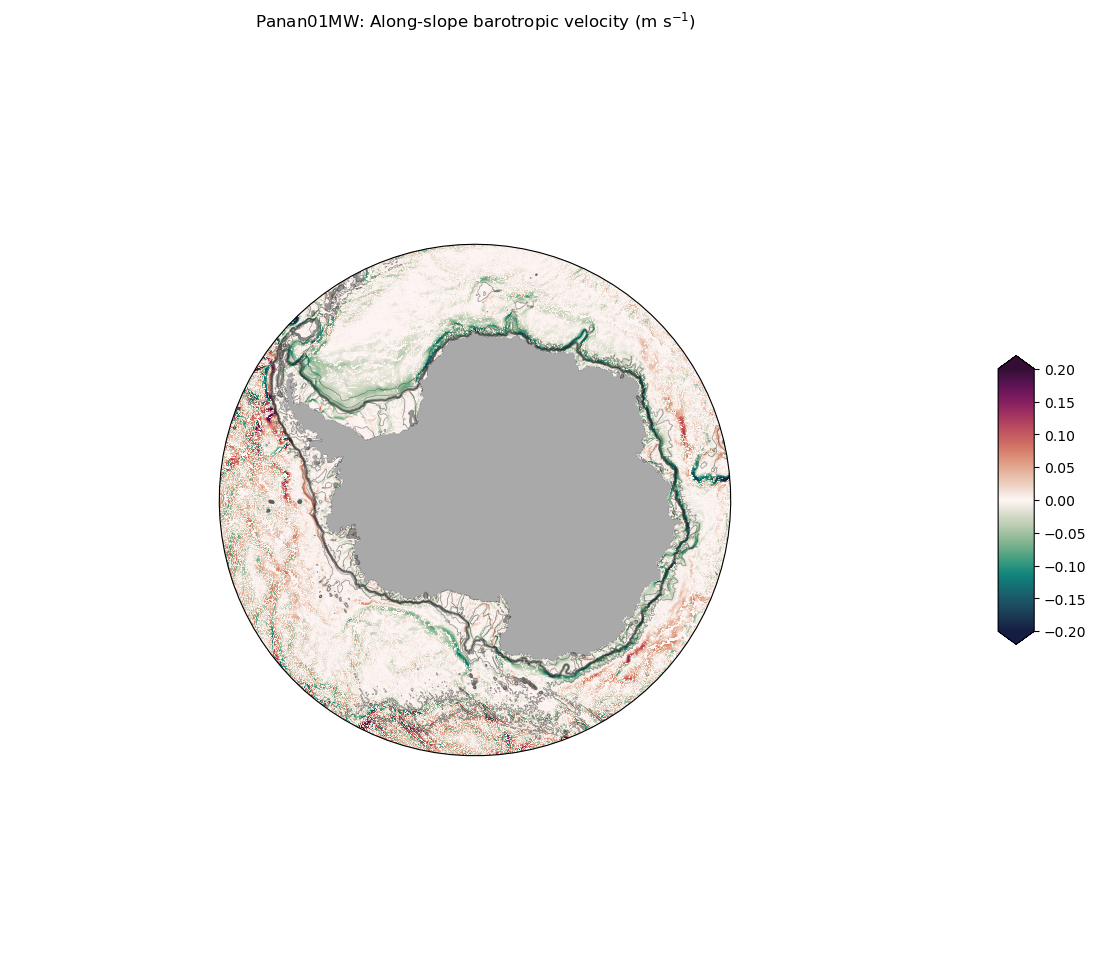

In [77]:
fig = plt.figure(1, figsize=(15, 15))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(), facecolor="darkgrey")
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
#land.plot.contourf(ax=ax, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)

# Coastline
#land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.25, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'black', linewidths=0.25,transform = ccrs.PlateCarree())

# Depth contours
data_fixed.deptho.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = barotropic_alongslope_velocity.plot(ax=ax, cmap=cm.cm.curl,
                                         transform=ccrs.PlateCarree(),
                                         vmin=-0.2, vmax=0.2,
                                         cbar_kwargs={'orientation': 'vertical',
                                                      'shrink': 0.25,
                                                      'extend': 'both',
                                                      'label': None,
                                                      'aspect': 8})
  
ax.set_title('Panan01MW: Along-slope barotropic velocity (m s$^{-1}$)');

# Anomaly 